# Facial Recognition using InceptionResnetV1 and VGGFace2

## Topic

In this notebook I will experiment with facial recognition using InceptionResnetV1 which is a hybrid architecture of the Inception network and ResNet network, which was pre-trained on the the VGGface2 dataset (a huge dataset containing millions of faces classified into thousands of classes. The dataset I will be using contains faces of bollywood celebrities (I chose only 5 people for the sake of fast training). So first I will use the cascade classifier to detect and crop faces in the pictures and then the InceptionResnetV1 to classify these pictures into classes representing the person they belong to. So let's get started !

## Objectives

- Detect faces contained in images
- Apply facial recognition pre-trained network to recognize the person in the picture

## Summary

- Importing libraries
- The dataset
- Data transforms and loaders
- Data visualization
- Building the network
- Training the network
- Testing the network
- Inference
- Conclusion

### Importing libraries

In [135]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import PIL
from PIL import Image
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import os
from os import listdir
from torchvision.io import read_image
import torchvision.transforms as T
import numpy as np
from glob import glob
import shutil
import cv2
import random
from facenet_pytorch import InceptionResnetV1

### The dataset

In [170]:
image_size = 140
batch_size = 20

In [52]:
files = glob("celebrities_images\*")
files

['celebrities_images\\Aamir Khan',
 'celebrities_images\\Abhay Deol',
 'celebrities_images\\Abhishek Bachchan',
 'celebrities_images\\Aishwarya Rai',
 'celebrities_images\\Ajay Devgn']

In [53]:
classes = ["Aamir Khan", "Abhay Deol", "Abhishek Bachchan", "Aishwarya Rai", "Ajay Devgn"]

In [54]:
aamir_files = glob('celebrities_images\\Aamir Khan\*')

In [80]:
def crop_faces(files):
    for file in files:
        img = cv2.imread(file)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
        faces = cascade.detectMultiScale(gray)
        if len(faces) > 0:
            for i, (x, y, w, h) in enumerate(faces):
                cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 255), 2)
                face = img[y:y + h, x:x + w]
                color_face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
                cv2.imwrite(f'face{random.randint(0,200)}.jpg', color_face)

In [56]:
crop_faces(aamir_files)

In [81]:
abhay_files = glob('celebrities_images\\Abhay Deol\*')

In [82]:
crop_faces(abhay_files)

In [83]:
abhishek_files = glob('celebrities_images\\Abhishek Bachchan\*')
crop_faces(abhishek_files)

In [84]:
aishwarya_files = glob('celebrities_images\\Aishwarya Rai\*')
crop_faces(aishwarya_files)

In [85]:
ajay_files = glob('celebrities_images\\Ajay Devgn\*')
crop_faces(ajay_files)

The first step I took was to stock the images paths into variables each with the name of the person they belong to and create a custum function that detects and crops the faces with the help of the cascade classifier contained withing cv2.

In [88]:
def train_test_split(files, path):
    files_train = files[:70]
    files_test = files[70:]
    for file in files_test:
        shutil.move(file, path)

In [98]:
aamir_files = glob('celebrities_images\\train\\Aamir Khan\*')
train_test_split(aamir_files, 'celebrities_images\\test\\Aamir Khan')

In [99]:
abhay_files = glob('celebrities_images\\train\\Abhay Deol\*')
train_test_split(abhay_files,'celebrities_images\\test\\Abhay Deol' )

In [100]:
abhishek_files = glob('celebrities_images\\train\\Abhishek Bachchan\*')
train_test_split(abhishek_files, 'celebrities_images\\test\\Abhishek Bachchan')

In [101]:
aishwarya_files = glob('celebrities_images\\train\\Aishwarya Rai\*')
train_test_split(aishwarya_files, 'celebrities_images\\test\\Aishwarya Rai')

In [102]:
ajay_files = glob('celebrities_images\\train\\Ajay Devgn\*')
train_test_split(ajay_files,'celebrities_images\\test\\Ajay Devgn' )

Next I created a simple function that would leave 70 images for training and the rest for testing and applied it on my images.

### Data transforms and loaders

In [171]:
data_dir = "celebrities_images/"
train_transforms = transforms.Compose([transforms.Resize(image_size),
                                       transforms.CenterCrop(image_size),
                                       transforms.RandomRotation(60),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize(image_size),
                                      transforms.CenterCrop(image_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [172]:
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

Then I specified some tranforms for the images to go through, for the training set I applied some augmentations sur as random flip and rotation, then transformed the images to normalized tensors.

In [173]:
valid_size = 0.1
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

I kept a small fraction of the training set (0.1) for validation

In [174]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [175]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size= batch_size,
                                          sampler = train_sampler, drop_last= True)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size= batch_size,
                                          sampler = valid_sampler, drop_last= True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size= batch_size, drop_last=True)

In [176]:
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

15
1
6


And I created the train, validation and test loaders and checked their sizes.

In [177]:
img, label = next(iter(train_loader))
print(img.shape)
print(label.shape)
print(img.min())
print(img.max())

torch.Size([20, 3, 140, 140])
torch.Size([20])
tensor(-2.1179)
tensor(2.6400)


### Data visualization

In [178]:
def imshow(img):
    img = img / 2 + 0.5 
    plt.imshow(np.transpose(img, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


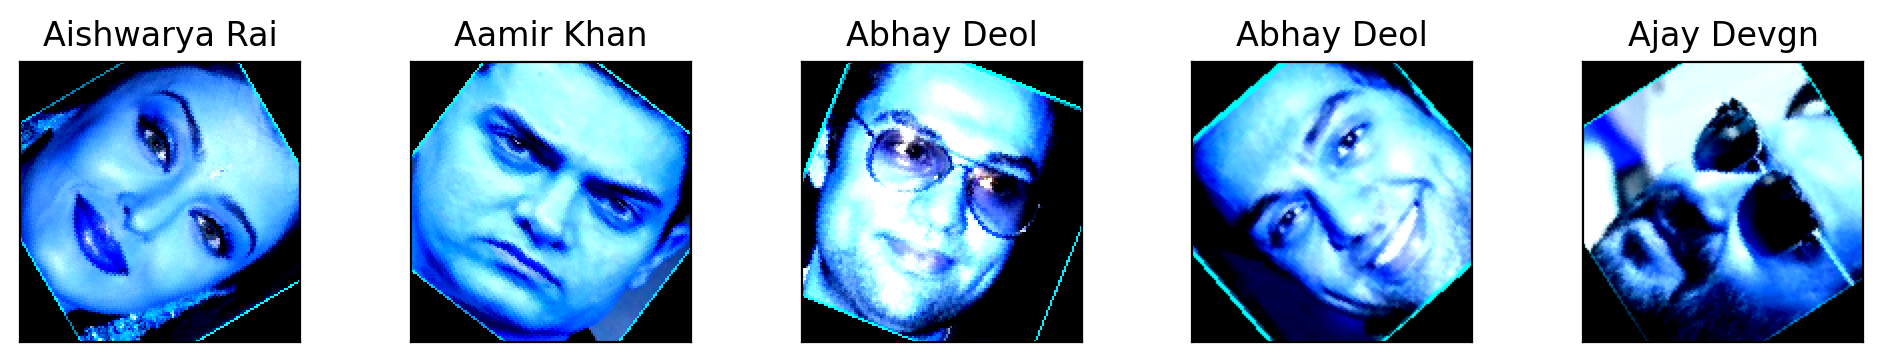

In [179]:
fig = plt.figure(figsize=(50, 4))

for idx in np.arange(5):
    ax = fig.add_subplot(2, 20, idx+1, xticks=[], yticks=[])
    imshow(img[idx])
    ax.set_title(classes[label[idx]])

Then I printed a couple of pictures from the train loader to see how my data looks like.

### Building the network

In [180]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.arc = InceptionResnetV1(pretrained='vggface2',
                                    classify = True,
                                    num_classes= len(classes))
    def forward(self, img):
        logits = self.arc(img)
        return logits

In [181]:
model = Model()
print(model)

Model(
  (arc): InceptionResnetV1(
    (conv2d_1a): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2d_2a): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2d_2b): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2d_3b): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_runn

Building the network is pretty straightforward, I just specified the architecture of the network which contains the pre-trained model (InceptionResnetV1) and specified the dataset it was trained on (VGGface2), I also specified the number of clases to be predicted. Then I set up the forwad function wich just passes the batches of images into the network and returns the logits corresponding to them.

### Training the network

In [183]:
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
epochs = 20

In [184]:
valid_loss_min = np.Inf
train_accuracy, val_accuracy = [],[]
for epoch in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    t_acc = 0.0
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        train_loss += loss.item()
        preds = F.log_softmax(logits, dim=1)
        ps = torch.exp(preds)
        top_k, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        t_acc += equals.sum().item()
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        model.eval()
        v_acc = 0.0
        for images, labels in valid_loader:
            logits = model(images)
            loss = criterion(logits, labels)
            valid_loss += loss.item()
            preds = F.log_softmax(logits, dim=1)
            ps = torch.exp(preds)
            top_k, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            v_acc += equals.sum().item()
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_accuracy.append(t_acc/len(train_loader.sampler))
    val_accuracy.append(v_acc/len(valid_loader.sampler))
        
    print("Epoch ", epoch+1, "train loss ", train_loss, "validation loss ", valid_loss)
        
    if valid_loss <= valid_loss_min:
        print("validation loss decreased", valid_loss_min, "---->", valid_loss)
        print("Saving the model")
        torch.save(model.state_dict(), "model_facial_rec.pt")
        valid_loss_min = valid_loss

            


Epoch  1 train loss  0.0744217766655816 validation loss  51.65690220424107
validation loss decreased inf ----> 51.65690220424107
Saving the model
Epoch  2 train loss  0.051922949722834996 validation loss  0.5616133553641183
validation loss decreased 51.65690220424107 ----> 0.5616133553641183
Saving the model
Epoch  3 train loss  0.036761616052143155 validation loss  0.02841557434626988
validation loss decreased 0.5616133553641183 ----> 0.02841557434626988
Saving the model
Epoch  4 train loss  0.03126135818541996 validation loss  0.030180750574384418
Epoch  5 train loss  0.03716489492900788 validation loss  0.04136763300214495
Epoch  6 train loss  0.03273115673708537 validation loss  0.03118177822657994
Epoch  7 train loss  0.02903693233217512 validation loss  0.026740309170314242
validation loss decreased 0.02841557434626988 ----> 0.026740309170314242
Saving the model
Epoch  8 train loss  0.022198518874153257 validation loss  0.01859570401055472
validation loss decreased 0.026740309170

Before starting the training loop I specified the optimizer and learning rate as well as the loss function (cross entropy for multiclass classification). The training ran over 20 epochs, in each epoch I provided my data batches to ba passed through the network, then I applied log softmax to get the logs of the probabilities that the pictures correspond to each of the 5 classes, then I applied the exponential function the get the actual probabilities, I chose the highest score probability and compared the class to which the score belongs with the actual label to get the accuracy of the training, finally I claculated and back propagated through the loss to update the gradients. For the validation loop it is the same as training expect that the network was on evalute mode i.e no gradients to be updated.

In [185]:
model.load_state_dict(torch.load("model_facial_rec.pt"))

<All keys matched successfully>

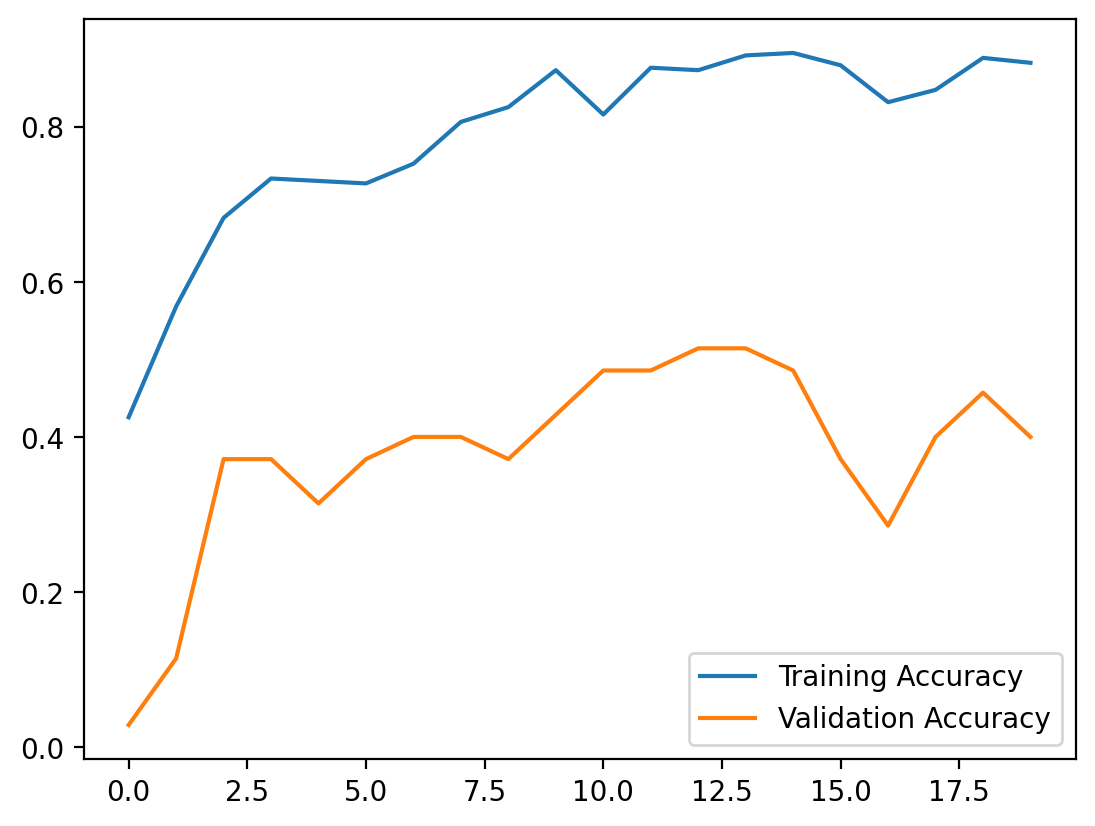

In [187]:
plt.plot(train_accuracy, label="Training Accuracy")
plt.plot(val_accuracy, label="Validation Accuracy")
plt.legend()


The I plotted the training VS validation accuracy, they both seem to move in the same way although the training accuracy is higher than the validation accuracy. I can't say for sure that my model is overfitting because the training VS validation erros shown above move in pretty much the same pace and there isn't much difference between them.

### Testing the network

In [188]:
test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

model.eval()

for data, target in test_loader:
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    p = F.log_softmax(output, dim=1)
    _, pred = torch.max(p, 1)    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) 
    for i in range(len(target)):

        label = target.data[i]
    
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(4):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.303499

Test Accuracy of Aamir Khan: 78% (30/38)
Test Accuracy of Abhay Deol: 60% ( 6/10)
Test Accuracy of Abhishek Bachchan: 92% (12/13)
Test Accuracy of Aishwarya Rai: 100% (47/47)

Test Accuracy (Overall): 87% (105/120)


During the testing phase, I passed my testing instances through the model and calculated the testing loss, the accuracy for each unique class and the overall accuracy which is up to 87% which I believe is a great score.

### Inference

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

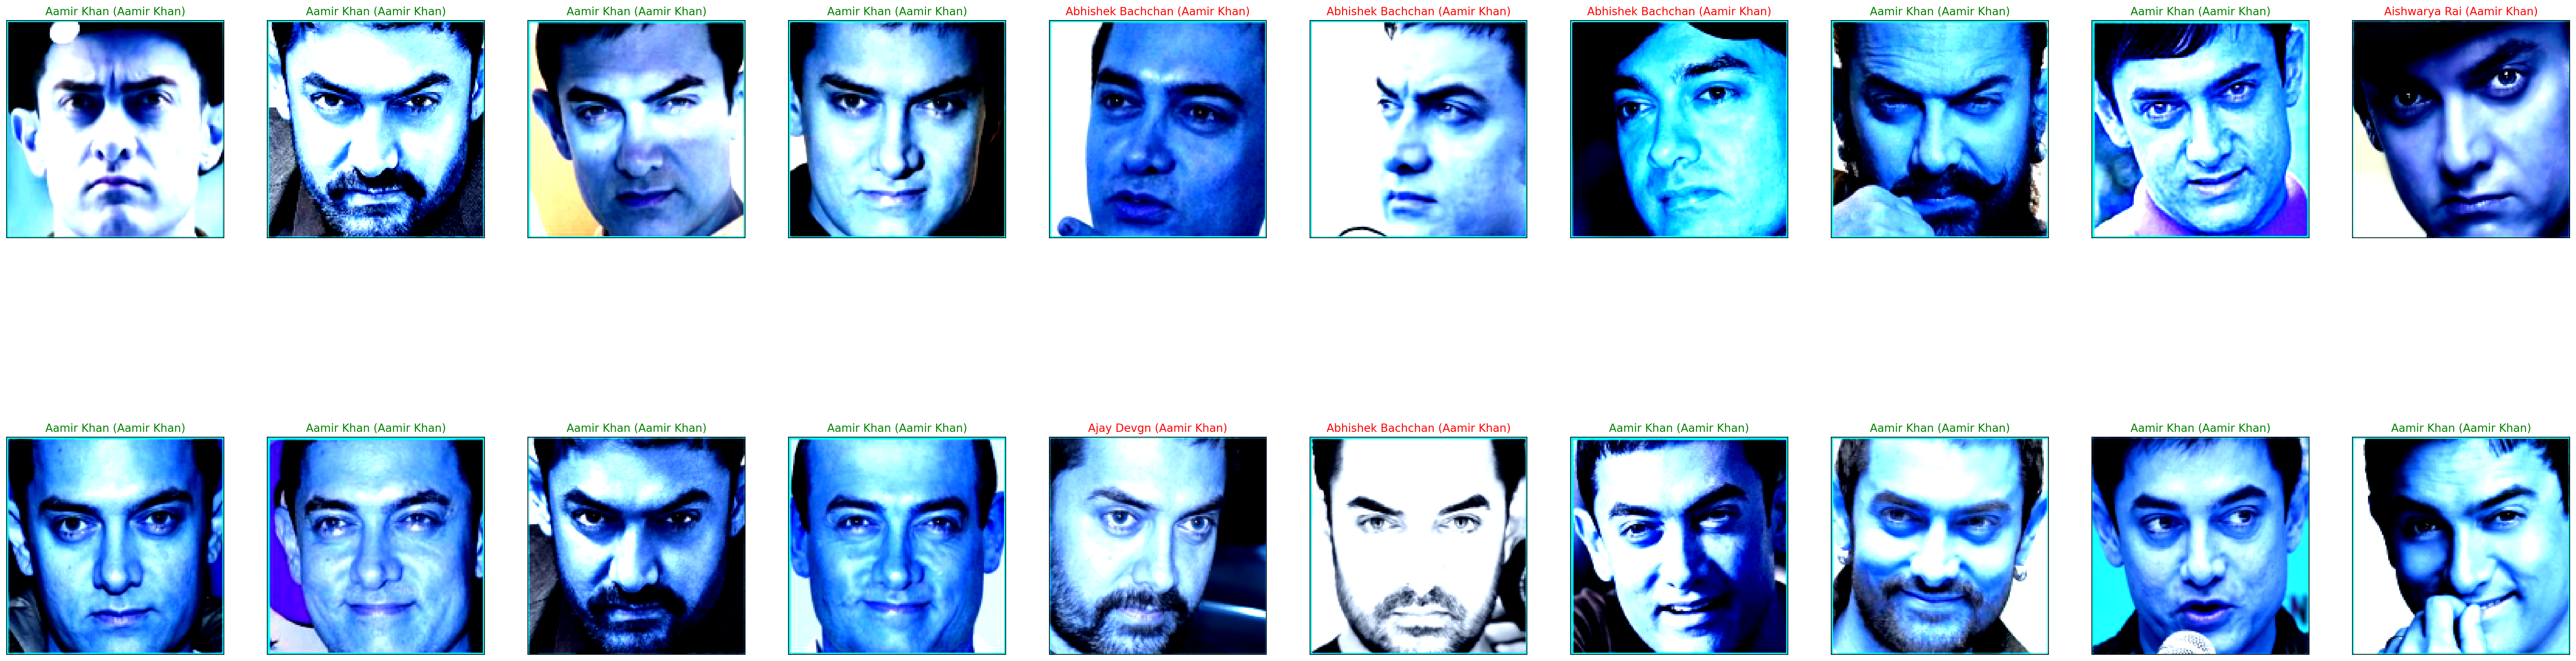

In [193]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

output = model(images)
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) 

fig = plt.figure(figsize=(50, 15))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

Finally I did some inference by plotting images and their labels against the predictions of the network, and I can see that most images were classified correctly so I'm pleased with the results of my network.

## Conclusion

In this project I had the chance to experiment with a pre-trained network and use transfer learning to implement a multiclass classification task. The goal was to detect and classify faces as belonging to one of the five celebrities present in the dataset. I used the cascade classifier to detect and crop the faces first, then I used InceptionResnetV1 which was trained on the VGGface2 dataset to perform facial recognition. The results of the model were rather good as it reached an error of only 0.3 on the testing set and an accuracy of 87%.